In [86]:
import os
import sys
sys.path.append(os.path.expanduser('/rds/rds-clecat/generative_modelling/STL-Dev'))

In [44]:
import scipy.stats as stats

In [45]:
from astropy import units as u
from astropy.cosmology import Planck15

Conversion freq=353GHz + from freq to temperature + from Jy/sr to micro kelvin 

In [46]:
freq = 355 * u.GHz 
equiv = u.thermodynamic_temperature(freq, Planck15.Tcmb0)
1/( (1. * u.uK).to(u.Jy /u.sr, equivalencies=equiv) )

<Quantity 0.00341424 sr / Jy>

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.fft
import healpy as hp
from importlib import reload
from functools import partial
import sys

In [48]:
torch.cuda.is_available()

True

/tmp/ipykernel_1705443/3699519137.py:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  CIB353 = 0.003414237*hp.read_map('/rds/rds-clecat/generative_modelling/lensed_CIB_rot_BANDPASS_F353_three_params1.fits', dtype=None, verbose=False)


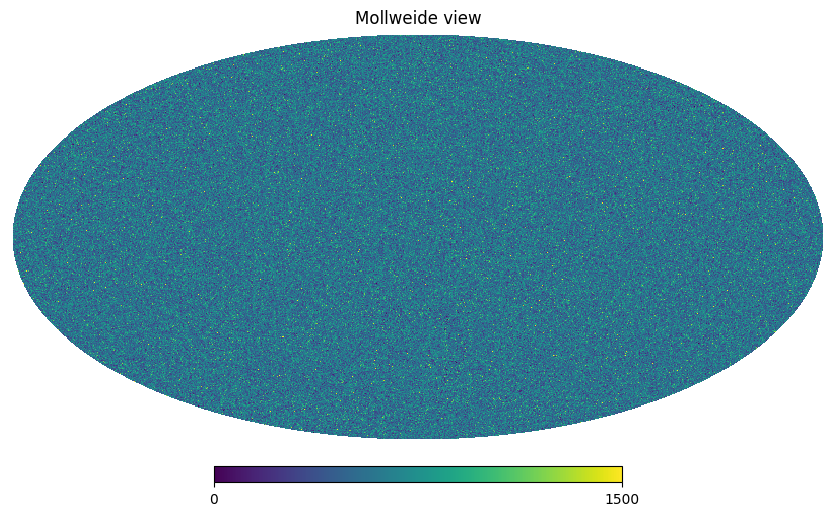

In [49]:
CIB353 = 0.003414237*hp.read_map('/rds/rds-clecat/generative_modelling/lensed_CIB_rot_BANDPASS_F353_three_params1.fits', dtype=None, verbose=False)
hp.mollview(CIB353, min=0, max=1.5e3)
plt.show()

In [50]:
import healpy as hp

nside = hp.get_nside(CIB353)
print("NSIDE =", nside)

NSIDE = 4096


The map resolution is : 1.72 arcmin


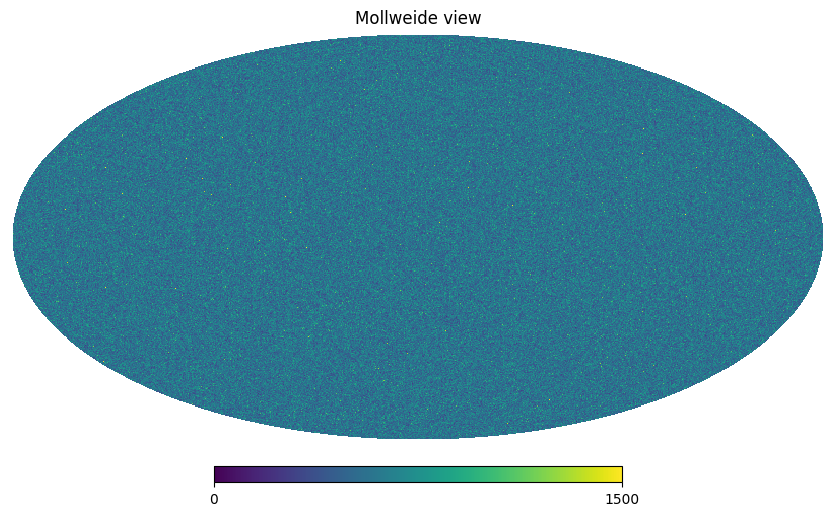

In [51]:
nside = 2048
CIB_353 = hp.ud_grade(CIB353, nside_out=nside)

resol = hp.nside2resol(nside) # [rad]
resol_arcmin = np.rad2deg(resol) * 60
print('The map resolution is :', np.round(resol_arcmin, 2), 'arcmin')

hp.mollview(CIB_353, min= 0, max=1.5e3)
plt.show()

Gaussian beam fmwh = 1.4 arcmin

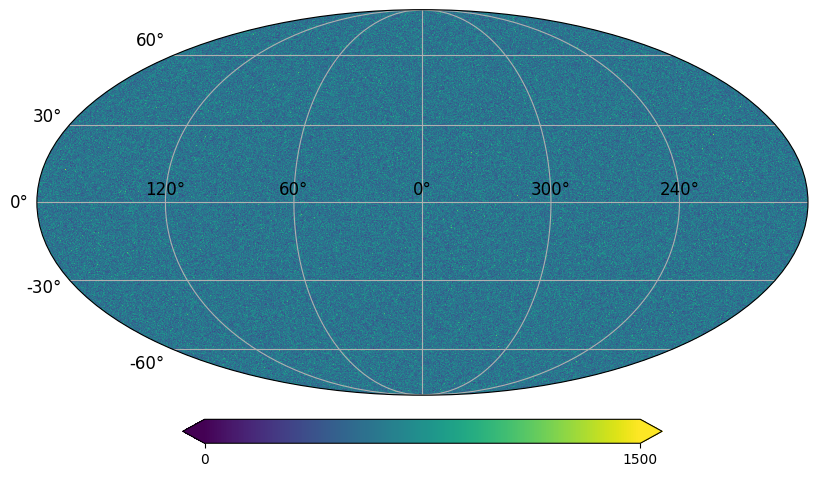

In [52]:
SObeam_fwhm = np.deg2rad(1.4 / 60) # [rad] 

CIB353_smooth = hp.smoothing(np.array(CIB_353), fwhm=SObeam_fwhm)
hp.projview(CIB353_smooth, min=0, max=1.5e3, graticule=True, graticule_labels=True)

plt.show()

Extract a patch

In [53]:
npix = 256
patch_size = 10  # degrees
reso_arcmin = patch_size * 60 / npix  # arcmin/pixel

In [54]:
#Center of the patch
lon0 = 0.0   # degrés
lat0 = 0.0   # degrés

proj = hp.projector.GnomonicProj(
    rot=(lon0, lat0, 0),
    coord='G',              
    reso=reso_arcmin,      
    xsize=npix,
    ysize=npix
)

# Extraction du patch
patch = proj.projmap(
    CIB353_smooth,
    vec2pix_func=partial(hp.vec2pix, nside)
)

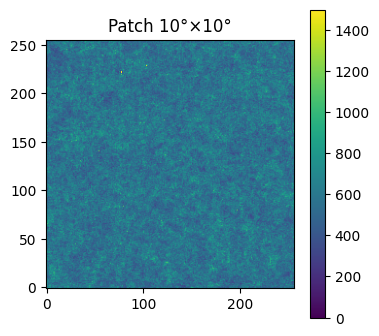

In [55]:
plt.figure(figsize=(4, 4))
im = plt.imshow(patch, vmin=0, vmax=1.5e3, origin='lower')
plt.colorbar(im)
plt.title("Patch 10°×10°")
plt.show()

In [56]:
def power_spectrum(image):
    assert image.shape[0] == image.shape[1]    
    n = image.shape[0]

    fourier = np.fft.fftn(image)
    amplitude = (np.abs(fourier) ** 2).flatten()

    kfreq = np.fft.fftfreq(n) * n
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = (kfreq2D[0] ** 2 + kfreq2D[1] ** 2).flatten() ** (1 / 2)

    kbins = np.arange(1/2, n // 2 + 1, 1)
    kvals = (kbins[1:] + kbins[:-1]) / 2
    bins, _, _ = stats.binned_statistic(knrm, amplitude, statistic = "mean", bins = kbins)
    
    return kvals, bins

def plot_power_spectra(samples):
    """
    Plots the mean power spectra for given image samples, with error bars.

    Parameters:
        samples: List of tuples (sample_images, color, label)
            - sample_images: List of 2D numpy arrays (grayscale images)
            - color: Plot color
            - label: Legend label
    """

    plt.figure(figsize=(8, 6))  # Single plot for power spectra

    for sample_images, color, label in samples:
        power_spectra_full = []  # Stores bootstrapped power spectra

        # Compute power spectra for each image
        for image in sample_images:
            k, bins = power_spectrum(image)  # Function assumed to exist
            power_spectra_full.append(bins)

        # Convert to NumPy array
        power_spectra_full = np.array(power_spectra_full)

        if len(sample_images) == 1:
            # Plot for a single image (no uncertainty)
            plt.plot(k, power_spectra_full[0], label=label, color=color, alpha=1.0)

        else:
            # Compute mean and confidence intervals
            mean_power = np.mean(power_spectra_full, axis=0)
            lower_bound_68 = np.percentile(power_spectra_full, 16, axis=0)
            upper_bound_68 = np.percentile(power_spectra_full, 84, axis=0)
            lower_bound_95 = np.percentile(power_spectra_full, 2.5, axis=0)
            upper_bound_95 = np.percentile(power_spectra_full, 97.5, axis=0)

            # Plot power spectrum with error bands
            #plt.fill_between(k, lower_bound_95, upper_bound_95, color=color, alpha=0.3)
            plt.fill_between(k, lower_bound_68, upper_bound_68, color=color, alpha=0.5, label=label)
            plt.plot(k, mean_power, color=color, alpha=1.0)

    # Final plot formatting
    plt.xlabel(r"Wavenumber $k$")
    plt.ylabel(r"Power Spectrum $P(k)$")
    plt.xscale("log")  # Usually power spectra are shown in log scale
    plt.yscale("log")
    plt.legend()
    plt.title("Power Spectra with Confidence Intervals")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)

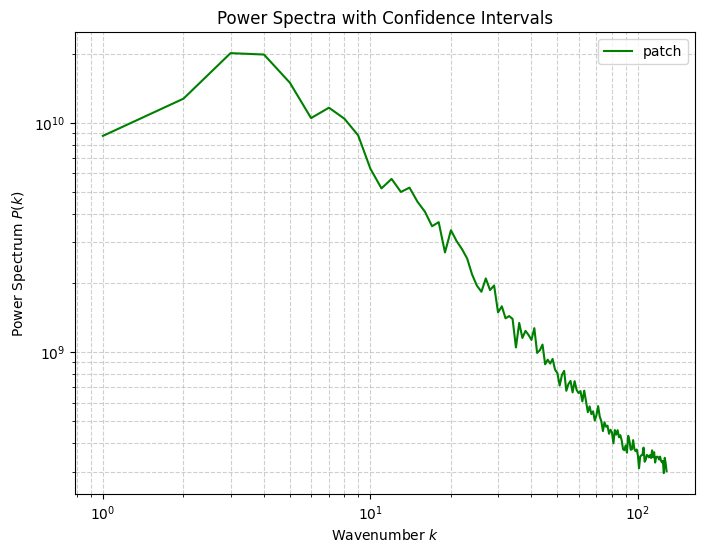

In [57]:
plot_power_spectra([([patch], "green", "patch")])
plt.show()

In [58]:
np.shape(patch)

(256, 256)

# Generate patches with fft + random phase

In [59]:
def get_random_data(target, M, N, mode='image'):
    '''
    get a gaussian random field with the same power spectrum as the image 'target' (in the 'image' mode),
    or with an assigned power spectrum function 'target' (in the 'func' mode).
    '''
    
    if mode == 'func':
        random_phase = np.random.normal(0,1,(M//2-1,N-1)) + np.random.normal(0,1,(M//2-1,N-1))*1j
        random_phase_left = (np.random.normal(0,1,(M//2-1)) + np.random.normal(0,1,(M//2-1))*1j)[:,None]
        random_phase_top = (np.random.normal(0,1,(N//2-1)) + np.random.normal(0,1,(N//2-1))*1j)[None,:]
        random_phase_middle = (np.random.normal(0,1,(N//2-1)) + np.random.normal(0,1,(N//2-1))*1j)[None,:]
        random_phase_corners = np.random.normal(0,1,3)
    if mode == 'image':
        random_phase = np.random.rand(M//2-1,N-1)
        random_phase_left = np.random.rand(M//2-1)[:,None]
        random_phase_top = np.random.rand(N//2-1)[None,:]
        random_phase_middle = np.random.rand(N//2-1)[None,:]
        random_phase_corners = np.random.randint(0,2,3)/2
    gaussian_phase = np.concatenate((
                      np.concatenate((random_phase_corners[1][None,None],
                                      random_phase_left,
                                      random_phase_corners[2][None,None],
                                      -random_phase_left[::-1,:],
                                    ),axis=0),
                      np.concatenate((np.concatenate((random_phase_top,
                                                      random_phase_corners[0][None,None],
                                                      -random_phase_top[:,::-1],
                                                    ),axis=1),
                                      random_phase, 
                                      np.concatenate((random_phase_middle, 
                                                      np.array(0)[None,None], 
                                                      -random_phase_middle[:,::-1],
                                                    ),axis=1), 
                                      -random_phase[::-1,::-1],
                                    ),axis=0),
                                    ),axis=1)
    

    if mode == 'image':
        gaussian_modulus = np.abs(np.fft.fftshift(np.fft.fft2(target)))
        gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_modulus*np.exp(1j*2*np.pi*gaussian_phase)))
    if mode == 'func':
        X = np.arange(0,M)
        Y = np.arange(0,N)
        Xgrid, Ygrid = np.meshgrid(X,Y)
        R = ((Xgrid-M/2)**2+(Ygrid-N/2)**2)**0.5
        gaussian_modulus = target(R)
        gaussian_modulus[M//2, N//2] = 0
        gaussian_field = np.fft.ifft2(np.fft.fftshift(gaussian_modulus*gaussian_phase))
        
    data = np.fft.fftshift(np.real(gaussian_field))
    return data

In [60]:
num_pixel = patch.shape[0]
random_patch = get_random_data(
    patch,
    num_pixel,
    num_pixel,
    mode="image"
)

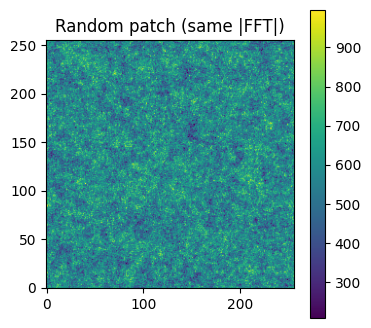

In [61]:
plt.figure(figsize=(4,4))
im = plt.imshow(random_patch, origin="lower")
plt.colorbar(im)
plt.title("Random patch (same |FFT|)")
plt.show()


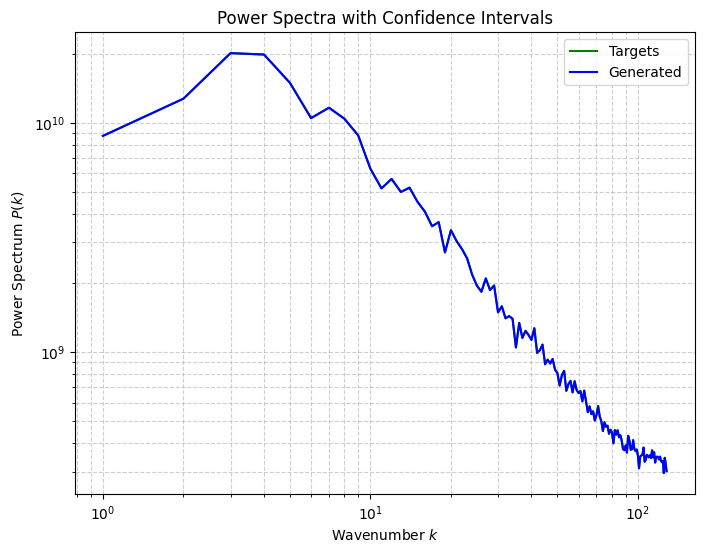

In [67]:
plot_power_spectra([
    ([patch], "green", "Targets"),
    ([random_patch], "b", "Generated"),
])
plt.show()

Generating more patches

In [68]:
num_pixel = patch.shape[0]

random_patches = []

for i in range(5):
    random_patch = get_random_data(
        patch,
        num_pixel,
        num_pixel,
        mode="image"
    )
    random_patches.append(random_patch)


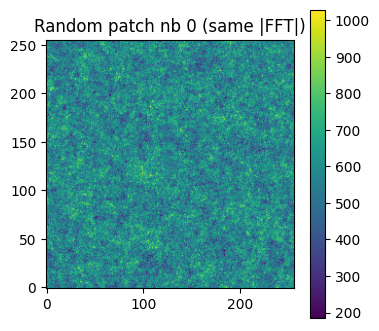

In [77]:
plt.figure(figsize=(4,4))
plt.imshow(random_patches[0], origin="lower")
plt.colorbar()
plt.title("Random patch nb 0 (same |FFT|)")
plt.show()


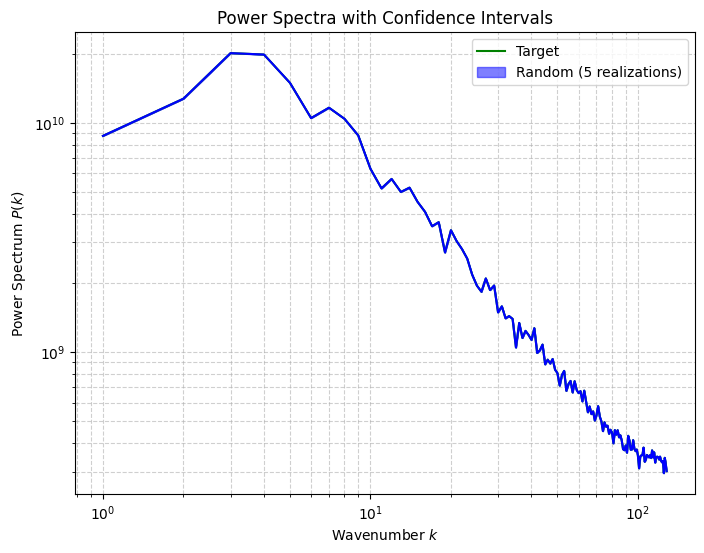

In [78]:
plot_power_spectra([
    ([patch], "green", "Target"),
    (random_patches, "b", "Random (5 realizations)"),
])
plt.show()

In [79]:
def plot_pdf(samples, num_bins=50, range=(-1, 60)):
    """
    Plots the probability density function (PDF) for given image samples with confidence intervals.

    Parameters:
        samples: List of tuples (sample_images, color, label)
            - sample_images: List of 2D numpy arrays (grayscale images)
            - color: Plot color
            - label: Legend label
        num_bins: Number of bins for histogram (default: 50)
    """

    plt.figure(figsize=(8, 6))  # Single plot for PDFs

    for sample_images, color, label in samples:
        pdfs_full = []  # Stores bootstrapped PDFs
        bin_edges = None  # Store bins

        # Compute PDF for each image
        for image in sample_images:
            pixel_values = image.flatten()  # Flatten image to 1D
            hist, bin_edges = np.histogram(pixel_values, bins=num_bins, range=range, density=True)  # Compute PDF
            pdfs_full.append(hist)

        # Convert to NumPy array
        pdfs_full = np.array(pdfs_full)

        # Compute bin centers
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        bw = bin_centers[1] - bin_centers[0]

        if len(sample_images) == 1:
            # Plot for a single image (no uncertainty)
            plt.plot(bin_centers, pdfs_full[0]*bw, label=label, color=color, alpha=1.0)

        else:
            # Compute mean and confidence intervals
            mean_pdf = np.mean(pdfs_full*bw, axis=0)
            lower_bound_68 = np.percentile(pdfs_full*bw, 16, axis=0)
            upper_bound_68 = np.percentile(pdfs_full*bw, 84, axis=0)
            lower_bound_95 = np.percentile(pdfs_full*bw, 2.5, axis=0)
            upper_bound_95 = np.percentile(pdfs_full*bw, 97.5, axis=0)

            # Plot PDF with error bands
            #plt.fill_between(bin_centers, lower_bound_95, upper_bound_95, color=color, alpha=0.3)
            plt.fill_between(bin_centers, lower_bound_68, upper_bound_68, color=color, alpha=0.5, label=label)
            plt.plot(bin_centers, mean_pdf, color=color, alpha=1.0)

    # Final plot formatting
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Probability Density Function (PDF)")
    plt.yscale("log")  # Often PDFs have a large dynamic range
    plt.legend()
    plt.title("PDF of Pixel Intensities with Confidence Intervals")
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    #plt.show()


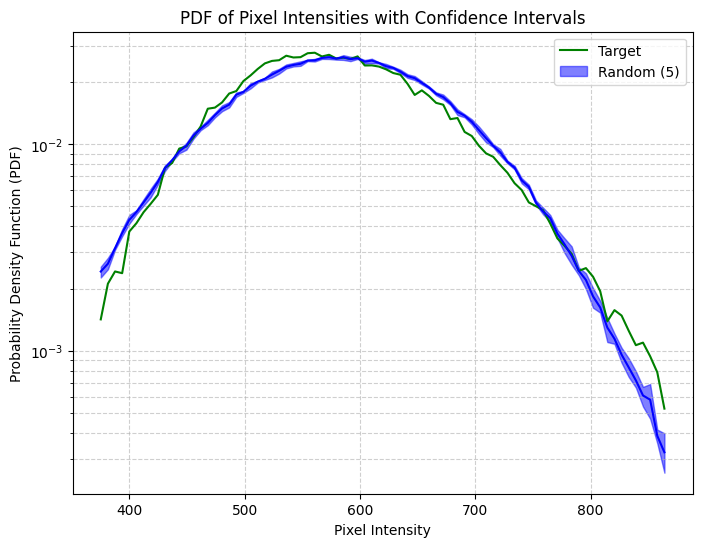

In [81]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch], "green", "Target"),
        (random_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.show()

# Benchmark synthesis

In [108]:
#iif it is good to detrend + drop the nan : 
#patch_target = patch.astype(np.float32)
#patch_target = np.nan_to_num(patch_target, nan=np.nanmean(patch_target), posinf=np.nanmean(patch_target), neginf=np.nanmean(patch_target))
#patch_target = patch_target - np.mean(patch_target)

In [109]:
#m = np.mean(patch_target)
#s = np.std(patch_target) + 1e-12
#patch_target = (patch_target - m) / s

In [87]:
from STL_main.STL_2D_Kernel_Torch import STL_2D_Kernel_Torch as DataClass
from STL_main.ST_Operator import ST_Operator as SO
from STL_main.Synthesis import optimize_scattering_LBFGS

In [89]:
target_data = DataClass(patch)
st_op_target = SO(target_data)

In [90]:
st_op_running = SO(target_data)

In [102]:
seed = 42

u, histo = optimize_scattering_LBFGS(
    patch,          #target
    DataClass,
    st_op_target=st_op_target,
    st_op_running=st_op_running,
    nbatch=4,
    max_iter=1200,          
    lr=0.01,
    history_size=50,
    print_iter=20,
    verbose=True,
    seed=seed,
)

Running synthesis on device cuda:0 dtype torch.float64
S2_ref of the ST_Op is overwrote
synthesis on 3968 ST coefficients
[LBFGS] inner iter 20, loss = 2.903650e+01
[LBFGS] inner iter 40, loss = 9.744744e+00
[LBFGS] inner iter 60, loss = 2.813350e+00
[LBFGS] inner iter 80, loss = 5.022075e-01
[LBFGS] inner iter 100, loss = 2.231915e-01
[LBFGS] inner iter 120, loss = 1.372834e-01
[LBFGS] inner iter 140, loss = 9.017729e-02
[LBFGS] inner iter 160, loss = 6.080170e-02
[LBFGS] inner iter 180, loss = 4.099889e-02
[LBFGS] inner iter 200, loss = 3.395998e-02
[LBFGS] inner iter 220, loss = 2.632019e-02
[LBFGS] inner iter 240, loss = 2.234055e-02
[LBFGS] inner iter 260, loss = 1.882548e-02
[LBFGS] inner iter 280, loss = 1.661103e-02
[LBFGS] inner iter 300, loss = 1.514705e-02
[LBFGS] inner iter 320, loss = 1.381524e-02
[LBFGS] inner iter 340, loss = 1.323306e-02
[LBFGS] inner iter 360, loss = 1.252971e-02
[LBFGS] inner iter 380, loss = 1.182064e-02
[LBFGS] inner iter 400, loss = 1.103821e-02
[L

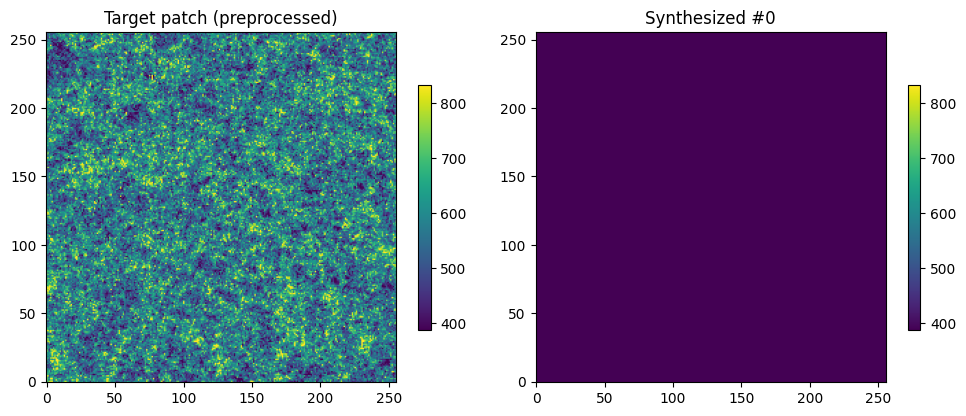

In [122]:
plt.figure(figsize=(10,4))
vmin, vmax = np.nanpercentile(patch, [1, 99])

plt.subplot(1,2,1)
plt.imshow(patch, origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Target patch (preprocessed)")

plt.subplot(1,2,2)
plt.imshow(u[0].cpu().numpy(), origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized #0")

plt.tight_layout()
plt.show()

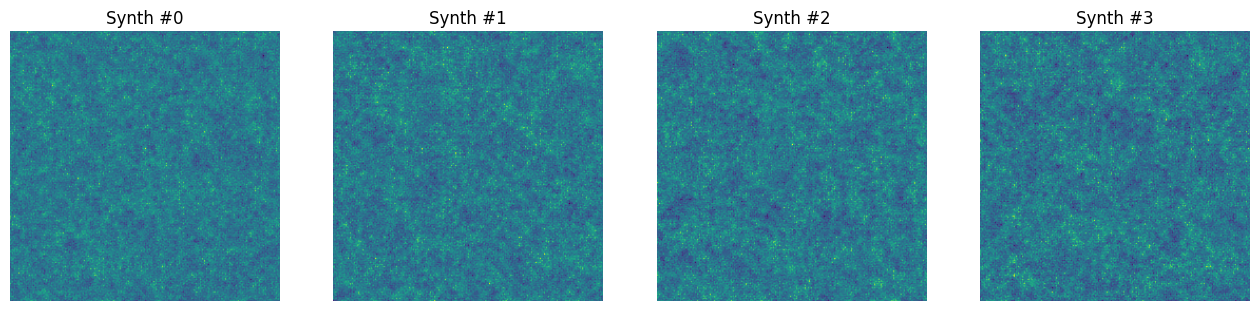

In [101]:
plt.figure(figsize=(16,4))
for k in range(u.shape[0]):  # ou range(nbatch)
    plt.subplot(1, u.shape[0], k+1)
    plt.imshow(u[k].cpu().numpy(), origin="lower")
    plt.axis("off")
    plt.title(f"Synth #{k}")
plt.show()


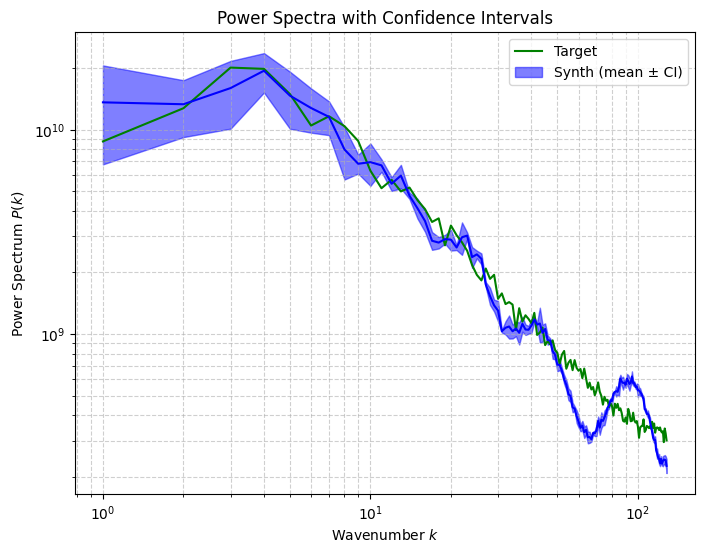

In [107]:
# u : tensor de shape (nbatch, H, W) typiquement
synth_patches = [u[k].detach().cpu().numpy() for k in range(u.shape[0])]
plot_power_spectra([
    ([patch], "green", "Target"),
    (synth_patches, "b", "Synth (mean ± CI)"),
])
plt.show()

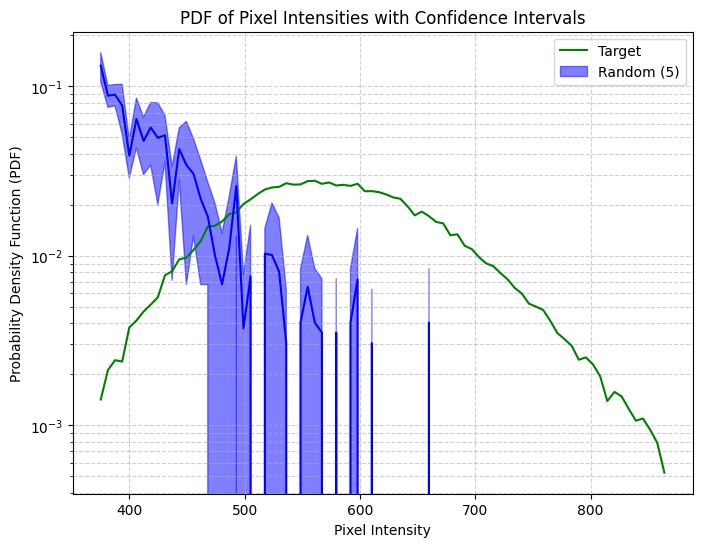

In [118]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch], "green", "Target"),
        (synth_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.show()

In [129]:
import torch
from STL_main.ST_Operator import ST_Operator as STO

l_data_nan = DataClass(patch.astype(np.float32))

st_op_nan = STO(
    l_data_nan,
    downsample_nan_weight_threshold=0.33,
    replace_nan_value=torch.nan
)

u, histo = optimize_scattering_LBFGS(
    patch_target,
    DataClass,
    st_op_target=st_op_nan,
    st_op_running=st_op_nan,
    nbatch=4,
    max_iter=200,
    lr=1.0,
    history_size=50,
    print_iter=20,
    verbose=True,
    seed=seed,
)

Running synthesis on device cuda:0 dtype torch.float32
synthesis on 3968 ST coefficients
[LBFGS] inner iter 20, loss = 3.405209e-01
[LBFGS] inner iter 40, loss = 5.902194e-02
[LBFGS] inner iter 60, loss = 2.449607e-02
[LBFGS] inner iter 80, loss = 1.490043e-02
[LBFGS] inner iter 100, loss = 1.063300e-02
[LBFGS] inner iter 120, loss = 8.472080e-03
[LBFGS] inner iter 140, loss = 7.054093e-03
[LBFGS] inner iter 160, loss = 6.109636e-03
[LBFGS] inner iter 180, loss = 5.408046e-03
[LBFGS] inner iter 200, loss = 4.816126e-03
212 iterations of synthesis done with nbatch=4 and 3968 ST coefficients
Execution time: 7.370 s


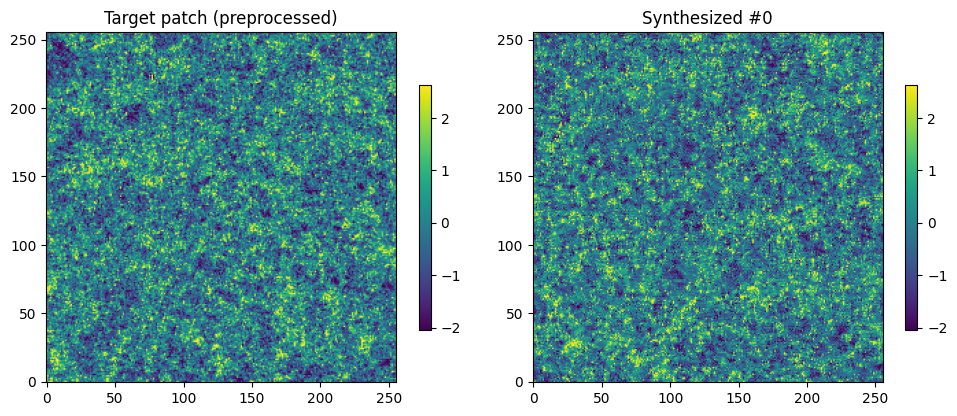

In [130]:
plt.figure(figsize=(10,4))

vmin, vmax = np.nanpercentile(patch_target, [1, 99])


plt.subplot(1,2,1)
plt.imshow(patch_target, origin="lower", vmin = vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Target patch (preprocessed)")

plt.subplot(1,2,2)
plt.imshow(u[0].cpu().numpy(), origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized #0")

plt.tight_layout()
plt.show()

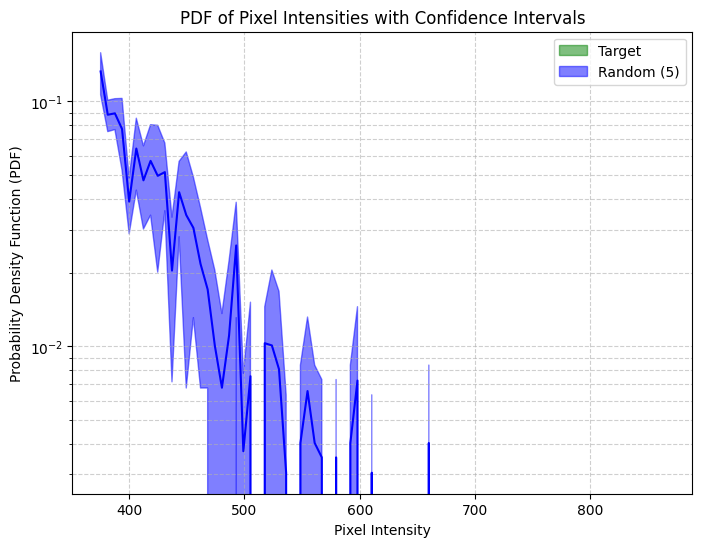

In [136]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch_target], "green", "Target"),
        (synth_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.show()

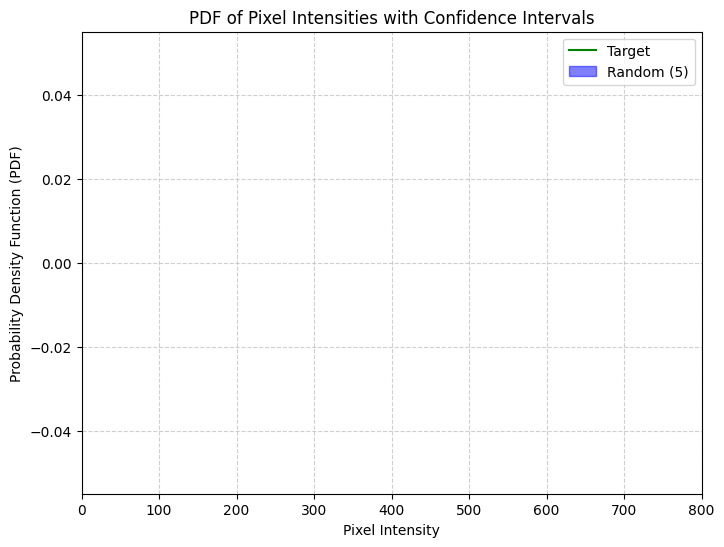

In [140]:
plot_pdf(
    [
        ([patch_target], "green", "Target"),
        (synth_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)

plt.xlim(0, 800)
plt.yscale("linear")   # <-- LIGNE CLÉ
plt.show()


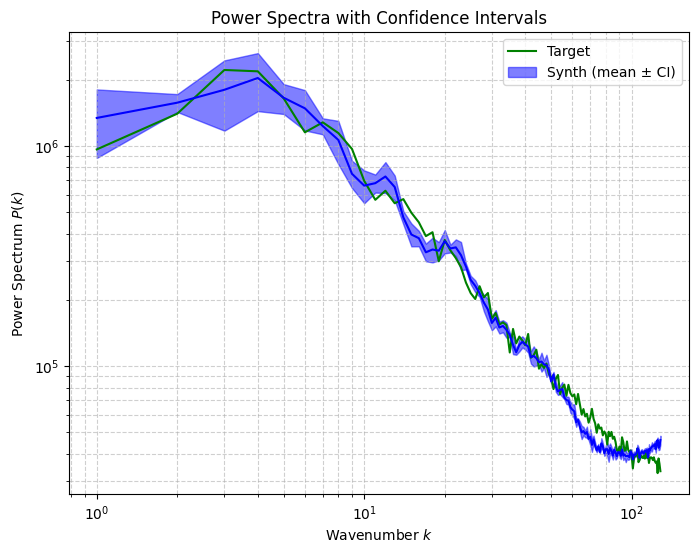

In [138]:
# u : tensor de shape (nbatch, H, W) typiquement
synth_patches = [u[k].detach().cpu().numpy() for k in range(u.shape[0])]
plot_power_spectra([
    ([patch_target], "green", "Target"),
    (synth_patches, "b", "Synth (mean ± CI)"),
])
plt.show()

In [126]:
import numpy as np
import torch
from STL_main.ST_Operator import ST_Operator as STO

seed = 42

# --- MINIMUM FIX: synthesize in log-space, then exp back ---

# 1) make patch positive + finite, then take log
patch_pos = patch_target.astype(np.float32)
m = np.nanmean(patch_pos)
patch_pos = np.nan_to_num(patch_pos, nan=m, posinf=m, neginf=m)

eps = 1e-6 * (np.nanstd(patch_pos) + 1e-12)
patch_pos = np.maximum(patch_pos, eps)

patch_log = np.log(patch_pos)

# 2) build operator + run synthesis on patch_log (NOT patch_target)
l_data_nan = DataClass(patch_log)

st_op_nan = STO(
    l_data_nan,
    downsample_nan_weight_threshold=0.33,
    replace_nan_value=torch.nan
)

u, histo = optimize_scattering_LBFGS(
    patch_log,          # <-- changed
    DataClass,
    st_op_target=st_op_nan,
    st_op_running=st_op_nan,
    nbatch=4,
    max_iter=2000,
    lr=0.01,
    history_size=50,
    print_iter=20,
    verbose=True,
    seed=seed,
)

# 3) back to physical space
u_lognormal = np.exp(u.detach().cpu().numpy())


Running synthesis on device cuda:0 dtype torch.float32
synthesis on 3968 ST coefficients
[LBFGS] inner iter 20, loss = 2.728235e+01
[LBFGS] inner iter 40, loss = 8.421326e+00
[LBFGS] inner iter 60, loss = 2.592456e+00
[LBFGS] inner iter 80, loss = 7.583649e-01
[LBFGS] inner iter 100, loss = 1.783794e-01
[LBFGS] inner iter 120, loss = 1.277274e-01
[LBFGS] inner iter 140, loss = 9.286020e-02
[LBFGS] inner iter 160, loss = 6.318628e-02
[LBFGS] inner iter 180, loss = 4.827794e-02
[LBFGS] inner iter 200, loss = 3.655039e-02
[LBFGS] inner iter 220, loss = 3.066811e-02
[LBFGS] inner iter 240, loss = 2.620365e-02
[LBFGS] inner iter 260, loss = 2.326869e-02
[LBFGS] inner iter 280, loss = 2.034210e-02
[LBFGS] inner iter 300, loss = 1.874618e-02
[LBFGS] inner iter 320, loss = 1.698499e-02
[LBFGS] inner iter 340, loss = 1.584822e-02
[LBFGS] inner iter 360, loss = 1.482069e-02
[LBFGS] inner iter 380, loss = 1.376080e-02
[LBFGS] inner iter 400, loss = 1.255535e-02
[LBFGS] inner iter 420, loss = 1.17

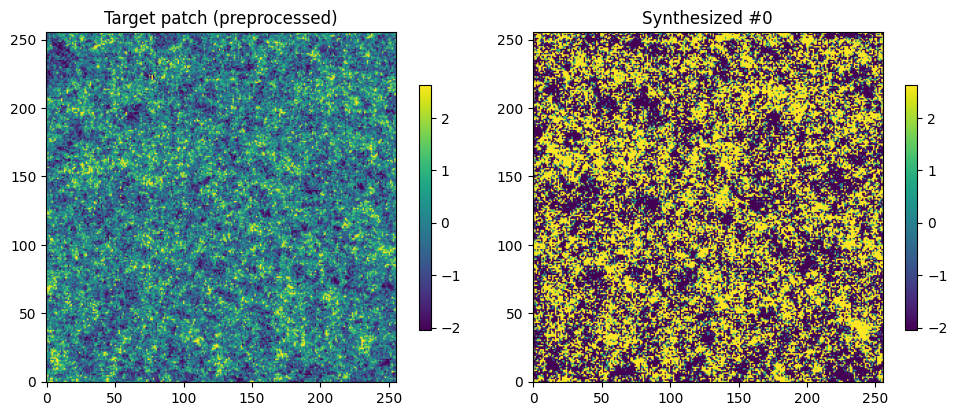

In [127]:
plt.figure(figsize=(10,4))
vmin, vmax = np.nanpercentile(patch_target, [1, 99])


plt.subplot(1,2,1)
plt.imshow(patch_target, origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Target patch (preprocessed)")

plt.subplot(1,2,2)
plt.imshow(u[0].cpu().numpy(), origin="lower",vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized #0")

plt.tight_layout()
plt.show()

/rds/rds-clecat/pipeline_alina_full/alina_paper/pipe_env/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


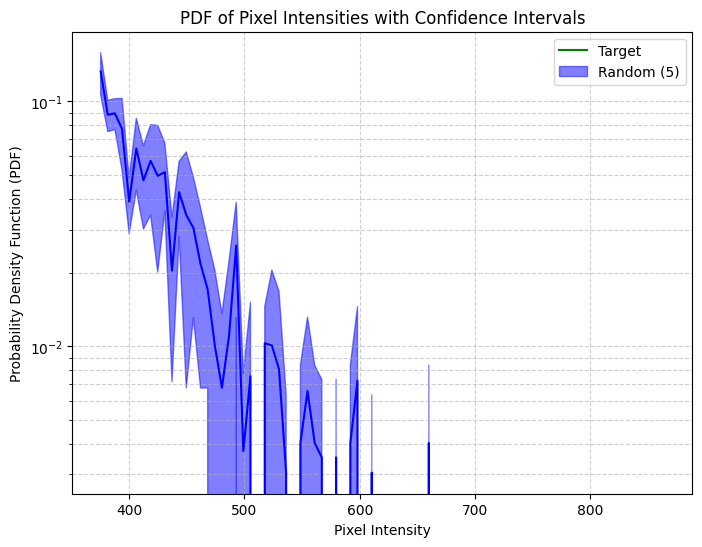

In [128]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch_target], "green", "Target"),
        (synth_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.show()

In [141]:
# Recover patch_target 

#iif it is good to detrend + drop the nan : 
patch_target1 = patch.astype(np.float32)
patch_target1 = np.nan_to_num(patch_target1, nan=np.nanmean(patch_target1), posinf=np.nanmean(patch_target1), neginf=np.nanmean(patch_target1))
patch_target1 = patch_target1 - np.mean(patch_target1)

In [142]:
import torch
from STL_main.ST_Operator import ST_Operator as STO

l_data_nan = DataClass(patch.astype(np.float32))

st_op_nan = STO(
    l_data_nan,
    downsample_nan_weight_threshold=0.33,
    replace_nan_value=torch.nan
)

u, histo = optimize_scattering_LBFGS(
    patch_target1,
    DataClass,
    st_op_target=st_op_nan,
    st_op_running=st_op_nan,
    nbatch=4,
    max_iter=200,
    lr=1.0,
    history_size=50,
    print_iter=20,
    verbose=True,
    seed=seed,
)

Running synthesis on device cuda:0 dtype torch.float32
synthesis on 3968 ST coefficients
[LBFGS] inner iter 20, loss = 1.206428e+01
[LBFGS] inner iter 40, loss = 2.319380e-01
[LBFGS] inner iter 60, loss = 4.722991e-02
[LBFGS] inner iter 80, loss = 2.087395e-02
[LBFGS] inner iter 100, loss = 1.339282e-02
[LBFGS] inner iter 120, loss = 1.003217e-02
[LBFGS] inner iter 140, loss = 8.166189e-03
[LBFGS] inner iter 160, loss = 7.129061e-03
[LBFGS] inner iter 180, loss = 6.350850e-03
[LBFGS] inner iter 200, loss = 5.812619e-03
215 iterations of synthesis done with nbatch=4 and 3968 ST coefficients
Execution time: 7.355 s


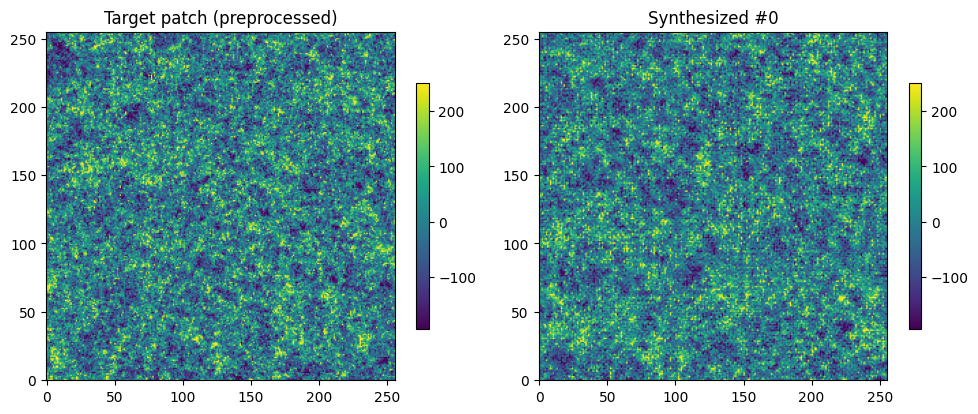

In [144]:
plt.figure(figsize=(10,4))

vmin, vmax = np.nanpercentile(patch_target1, [1, 99])


plt.subplot(1,2,1)
plt.imshow(patch_target1, origin="lower", vmin = vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Target patch (preprocessed)")

plt.subplot(1,2,2)
plt.imshow(u[0].cpu().numpy(), origin="lower", vmin=vmin, vmax=vmax)
plt.colorbar(shrink=0.7)
plt.title("Synthesized #0")

plt.tight_layout()
plt.show()

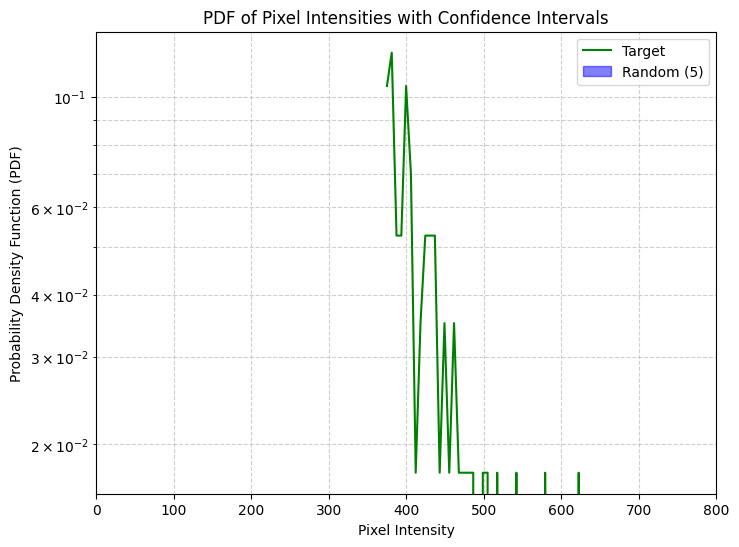

In [146]:
lo = np.percentile(patch, 0.5)
hi = np.percentile(patch, 99.5)

plot_pdf(
    [
        ([patch_target1], "green", "Target"),
        (synth_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(lo, hi)
)
plt.xlim(0, 800)
plt.show()

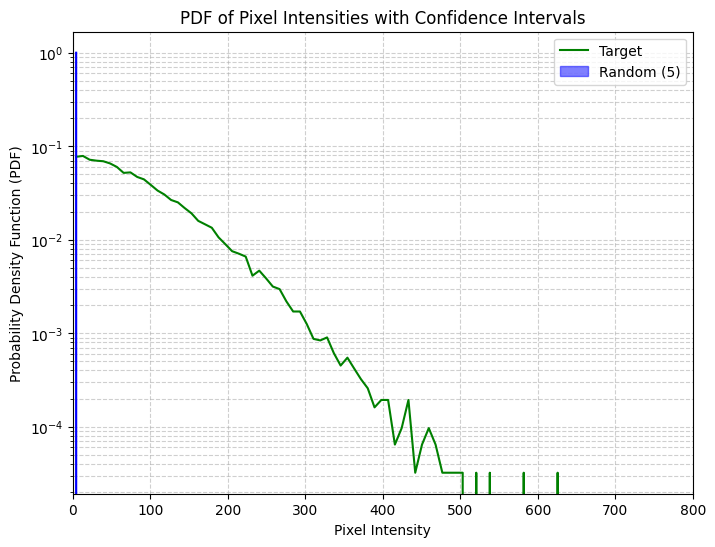

In [148]:
plot_pdf(
    [
        ([patch_target1], "green", "Target"),
        (synth_patches, "b", "Random (5)"),
    ],
    num_bins=80,
    range=(0, 700)      # <-- bins cohérents avec xlim
)
plt.xlim(0, 800)
plt.show()
